In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from dataset_split import create_train_valid_split, get_data_paths
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from torchvision import datasets

In [2]:
train_path, valid_path = get_data_paths()
def load_data(data_augmentation=False):
    transforms_original = transforms.Compose([
        v2.Resize((224,224)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    transforms_augmented = transforms.Compose([
        v2.Resize((224,224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomRotation(10),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.4)),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    
    if data_augmentation:
        train_orig_dataset = datasets.ImageFolder(root=train_path,transform=transforms_original)
        train_aug_dataset = datasets.ImageFolder(root=train_path,transform=transforms_augmented)
        train_dataset = torch.utils.data.ConcatDataset([train_orig_dataset, train_aug_dataset])
    else:
        train_dataset = datasets.ImageFolder(root=train_path,transform=transforms_original)
        
    valid_dataset = datasets.ImageFolder(root=r'valid_path',transform=transforms_original)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)

    return train_loader, valid_loader

In [3]:
train_loader,valid_loader = load_data(data_augmentation=True)
print(train_loader)

In [4]:
"""
def show_MRI_batch(dataloader, title="Batch of MRI Tumor Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting
            ax.imshow(img)
            ax.set_title(MRI.classes[labels[i]])
            ax.axis('off')
    plt.show()
    
show_MRI_batch(MRI_train_loader)
"""

'\ndef show_MRI_batch(dataloader, title="Batch of MRI Tumor Images"):\n    images, labels = next(iter(dataloader))\n    fig, axes = plt.subplots(4, 8, figsize=(15, 8))\n    fig.suptitle(title)\n    \n    for i, ax in enumerate(axes.flatten()):\n        if i < len(images):\n            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting\n            ax.imshow(img)\n            ax.set_title(MRI.classes[labels[i]])\n            ax.axis(\'off\')\n    plt.show()\n    \nshow_MRI_batch(MRI_train_loader)\n'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# Load pre-trained MobileNetV3 model
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = mobilenet_v3_small(weights=weights)
print(model)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [7]:
# Freeze all layers except the classifier
for param in model.features.parameters():
    param.requires_grad = False

# Change the number of output classes
num_classes = 3 
model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=num_classes)

model = model.to(device)
#print(model)

In [8]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Learning rate is set to 0.0001



In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step() 

            # Calculate accuracy
            _, predicted = outputs.max(1) 
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item() 
            running_loss += loss.item()
            
        accuracy = 100.0 * correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
                    f'Train Loss: {running_loss / 100:.4f}, Train Accuracy: {accuracy:.2f}%')
        valid_loss = valid_model(model, valid_loader) # Evaluate on validation set after each epoch


def valid_model(model, valid_loader):
    model.eval()  
    correct = 0
    total = 0
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            valid_loss += loss.item()  # Accumulate batch loss
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Valid Loss: {valid_loss / 100:.4f}, Valid Accuracy: {accuracy:.2f}%')

    return valid_loss, accuracy

In [10]:
num_epochs = 50
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/50], Train Loss: 0.7388, Train Accuracy: 67.29%
Valid Loss: 0.1095, Valid Accuracy: 58.06%
Epoch [2/50], Train Loss: 0.5842, Train Accuracy: 75.07%
Valid Loss: 0.0603, Valid Accuracy: 82.50%
Epoch [3/50], Train Loss: 0.4387, Train Accuracy: 82.47%
Valid Loss: 0.0501, Valid Accuracy: 85.00%
Epoch [4/50], Train Loss: 0.3782, Train Accuracy: 85.14%
Valid Loss: 0.0448, Valid Accuracy: 86.39%
Epoch [5/50], Train Loss: 0.3397, Train Accuracy: 86.39%
Valid Loss: 0.0426, Valid Accuracy: 86.67%
Epoch [6/50], Train Loss: 0.3212, Train Accuracy: 87.15%
Valid Loss: 0.0402, Valid Accuracy: 86.94%
Epoch [7/50], Train Loss: 0.2968, Train Accuracy: 88.12%
Valid Loss: 0.0387, Valid Accuracy: 88.06%
Epoch [8/50], Train Loss: 0.2739, Train Accuracy: 89.17%
Valid Loss: 0.0358, Valid Accuracy: 88.61%
Epoch [9/50], Train Loss: 0.2690, Train Accuracy: 88.92%
Valid Loss: 0.0349, Valid Accuracy: 88.61%
Epoch [10/50], Train Loss: 0.2539, Train Accuracy: 89.79%
Valid Loss: 0.0340, Valid Accuracy: 88.89%

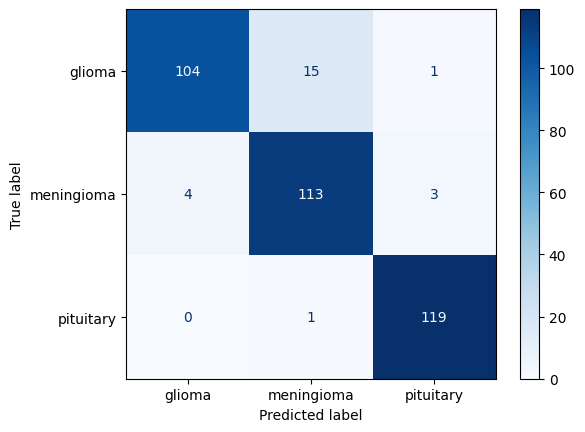

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.87      0.91       120
  meningioma       0.88      0.94      0.91       120
   pituitary       0.97      0.99      0.98       120

    accuracy                           0.93       360
   macro avg       0.94      0.93      0.93       360
weighted avg       0.94      0.93      0.93       360



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
class_names = ['glioma', 'meningioma', 'pituitary']
true_labels = []
predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

In [12]:
torch.save(model.state_dict(), 'brain_tumor_classifier.pth')